In [2]:
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, Dropout, GRU, Bidirectional
from keras import optimizers
from itertools import cycle
import itertools
from utils import read_data, extract_segments
from utils import plot_confusion_matrix, plotroc

"""Hyperparameters"""
win_size =5 
num_var = 10
split_ratio = 0.8

print("Loading Data from file......")
print("=============================")

train_data = read_data("train.csv")
print("Data loaded from file......")
print("=============================")

# Data preprocessing
print("Preprocessing and standardizing data for model input......")
print("=============================")
train_data

2023-05-31 16:53:15.737173: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-31 16:53:16.142945: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-31 16:53:16.144798: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-31 16:53:17.957637: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Loading Data from file......
Data loaded from file......
Preprocessing and standardizing data for model input......


,vector,task execution,score,packets received,packets sent,bytes received,bytes sent,num_of_processes,max_pid,malware_count
0,0,143,7.8,261,261,29524,29524,31,11208,89
1,0,156,0.4,196,196,20260,20260,50,7136,155
2,0,22,1.0,50,50,3836,3836,38,2496,10
3,0,144,7.8,217,217,25878,25878,32,2988,88
4,0,147,8.6,182,182,18454,18454,44,10952,126
...,...,...,...,...,...,...,...,...,...,...
11366,1,37,0.4,16,16,1024,1024,35,2320,10
11367,1,43,0.6,24,24,1623,1623,35,2276,10
11368,1,41,0.4,25,25,1699,1699,35,2320,10
11369,1,41,0.4,20,20,1256,1256,35,2312,10


In [3]:
def extract_segments(data, window_size):
    segments = None
    labels = np.empty((0))
    for (start, end) in windows(train_data, win_size):
        if (len(train_data.loc[start:end]) == (win_size)):
            signal = np.asarray(train_data.loc[start:end])[:,1:11]
            if segments is None:
                segments = signal
            else:
                segments = np.vstack([segments, signal])
            labels = np.append(labels, train_data.loc[start:end]["vector"][start])
    return segments, labels

def windows(data, window_size):
    start = 0
    while start < len(data):
        yield start, start + window_size - 1
        start += (window_size)
        
segments, labels = extract_segments(train_data, win_size)         
print("=======sements==========")
print(segments)
print("====================")
print("==========labels==========")
print(labels)
print("========================")



=======sements==========
[[1.4300e+02 7.8000e+00 2.6100e+02 ... 3.1000e+01 1.1208e+04 8.9000e+01]
 [1.5600e+02 4.0000e-01 1.9600e+02 ... 5.0000e+01 7.1360e+03 1.5500e+02]
 [2.2000e+01 1.0000e+00 5.0000e+01 ... 3.8000e+01 2.4960e+03 1.0000e+01]
 ...
 [4.3000e+01 6.0000e-01 2.4000e+01 ... 3.5000e+01 2.2760e+03 1.0000e+01]
 [4.1000e+01 4.0000e-01 2.5000e+01 ... 3.5000e+01 2.3200e+03 1.0000e+01]
 [4.1000e+01 4.0000e-01 2.0000e+01 ... 3.5000e+01 2.3120e+03 1.0000e+01]]
==========labels==========
[0. 0. 0. ... 1. 1. 1.]


In [4]:
segments = segments.astype(float)

labels = np.asarray(pd.get_dummies(labels), dtype=np.int8)
print("===updated=========")
print(labels)
print(("==updated========="))

num_var = segments.shape[1] # get number of variables
num_segments = len(segments) // win_size # calculate number of segments
print(num_var)
print(num_segments)

if num_segments * win_size < len(segments):
    num_segments += 1 # add one more segment if necessary

reshaped_segments = segments[:num_segments * win_size, :].reshape([num_segments, win_size, num_var])
print("Reshaped")
print(reshaped_segments)
print("Reshaped")

===updated=========
[[1 0]
 [1 0]
 [1 0]
 ...
 [0 1]
 [0 1]
 [0 1]]
==updated=========
9
2274
Reshaped
[[[1.4300e+02 7.8000e+00 2.6100e+02 ... 3.1000e+01 1.1208e+04 8.9000e+01]
  [1.5600e+02 4.0000e-01 1.9600e+02 ... 5.0000e+01 7.1360e+03 1.5500e+02]
  [2.2000e+01 1.0000e+00 5.0000e+01 ... 3.8000e+01 2.4960e+03 1.0000e+01]
  [1.4400e+02 7.8000e+00 2.1700e+02 ... 3.2000e+01 2.9880e+03 8.8000e+01]
  [1.4700e+02 8.6000e+00 1.8200e+02 ... 4.4000e+01 1.0952e+04 1.2600e+02]]

 [[2.1000e+01 1.0000e+00 5.5000e+01 ... 3.1000e+01 2.4560e+03 9.0000e+00]
  [1.4400e+02 8.2000e+00 2.6100e+02 ... 3.1000e+01 1.1248e+04 9.0000e+01]
  [2.9000e+01 1.0000e+00 7.1000e+01 ... 3.0000e+01 2.6560e+03 9.0000e+00]
  [2.7000e+01 4.0000e-01 7.7000e+01 ... 3.8000e+01 2.7200e+03 1.0000e+01]
  [1.4300e+02 7.8000e+00 2.6100e+02 ... 3.1000e+01 1.1208e+04 8.9000e+01]]

 [[1.5600e+02 8.4000e+00 2.0500e+02 ... 4.2000e+01 1.3296e+04 1.0900e+02]
  [1.3800e+02 7.8000e+00 2.5000e+02 ... 5.5000e+01 2.9880e+03 9.0000e+01]
  [2.

In [5]:
# """Create Train and Test Split based on split ratio"""
train_test_split = np.random.rand(len(reshaped_segments)) < split_ratio
print(len(train_test_split))
train_x = reshaped_segments[train_test_split]
train_y = labels[train_test_split]
test_x = reshaped_segments[~train_test_split]
test_y = labels[~train_test_split]

def standardize(train, test):
    mean = np.mean(train, axis=0)
    std = np.std(train, axis=0)+0.000001
    train_x = (train - mean) / std 
    test_x = (test - mean) / std 
    return train_x, test_x

train_x, test_x = standardize(train_x, test_x)

print("Preprocessing Done......")
print("=============================")
print("Buiding model......")
print("=============================")
# input_shape=(timesteps, in_size)
print("x => train")
print(train_x)
print("x=>test")
print(test_x)   

2274
Preprocessing Done......
Buiding model......
x => train
[[[ 0.76616993  1.55831381  1.78089072 ... -0.17220113  1.8269683
    0.92503432]
  [ 0.92494497 -0.77500957  0.99719701 ... -0.10872514  0.78631737
    2.23672471]
  [-0.85491137 -0.60273295 -0.82940466 ... -0.14647887 -0.52903173
   -0.74100353]
  [ 0.74661638  1.51889704  1.26856757 ... -0.16532898 -0.36932556
    0.90557454]
  [ 0.80664501  1.82757481  0.81051197 ... -0.14625133  1.88764214
    1.67354611]]

 [[-0.8677685  -0.58303977 -0.75160309 ... -0.17220113 -0.53230376
   -0.73796919]
  [ 0.76618052  1.70673562  1.80471643 ... -0.17894705  1.93519509
    0.90572677]
  [-0.76352235 -0.60273295 -0.57263841 ... -0.17562619 -0.48551611
   -0.76150711]
  [-0.77409194 -0.78576579 -0.4892901  ... -0.14287968 -0.44368468
   -0.73358834]
  [ 0.7527151   1.57261633  1.79402134 ... -0.18956545  1.96013068
    0.90546202]]

 [[ 0.94027813  1.74725677  1.0924458  ... -0.13233492  2.38982937
    1.3407852 ]
  [ 0.68679829  1.57946

In [6]:
model = Sequential()
model.add(Bidirectional(LSTM(units=128,  input_dim=num_var, input_length=win_size,  return_sequences=True, dropout=0.2), input_shape=(win_size, num_var)))
model.add(Bidirectional(LSTM(128, return_sequences=True, dropout=0.2)))
model.add(Bidirectional(LSTM(64, return_sequences=True, dropout=0.2)))
model.add(Bidirectional(LSTM(64, return_sequences=False, dropout=0.3)))
model.add(Dense(2, activation='sigmoid'))
opt = optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=opt, loss='binary_crossentropy',metrics=['accuracy'])
model.summary()
    

2023-05-31 16:53:52.393720: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-31 16:53:52.394902: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-31 16:53:52.396026: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, 5, 256)           141312    
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 5, 256)           394240    
 nal)                                                            
                                                                 
 bidirectional_2 (Bidirectio  (None, 5, 128)           164352    
 nal)                                                            
                                                                 
 bidirectional_3 (Bidirectio  (None, 128)              98816     
 nal)                                                            
                                                                 
 dense (Dense)               (None, 2)                 2

2023-05-31 16:53:53.439195: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-31 16:53:53.440432: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-31 16:53:53.441576: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Total params: 798,978
Trainable params: 798,978
Non-trainable params: 0
_________________________________________________________________


In [9]:
print("Buiding Done......")
print("=============================")
print("Training model......")
print("=============================")

# Fit the network
history = model.fit(train_x, train_y, epochs=40, batch_size=64,verbose=1, validation_data=(test_x, test_y))
print("Training DONE!!......")
print("=============================")
print("Saving weights!!......")
print("=============================")
# serialize model to JSON
model_json = model.to_json()
with open("malware_bidirectional_model_1.json", "w") as json_file:
     json_file.write(model_json)
    # serialize weights to HDF5
model.save_weights("malware_bidirectional_model_1.h5")
print("Saved model to disk.....")
print("Representing Results......")
print("=============================")

Buiding Done......
Training model......
Epoch 1/40
29/29 [==============================] - 3s 95ms/step - loss: 0.0713 - accuracy: 0.9737 - val_loss: 0.1050 - val_accuracy: 0.9598
Epoch 2/40
29/29 [==============================] - 2s 84ms/step - loss: 0.0716 - accuracy: 0.9726 - val_loss: 0.0966 - val_accuracy: 0.9576
Epoch 3/40
29/29 [==============================] - 2s 77ms/step - loss: 0.0726 - accuracy: 0.9748 - val_loss: 0.1032 - val_accuracy: 0.9598
Epoch 4/40
29/29 [==============================] - 2s 82ms/step - loss: 0.0753 - accuracy: 0.9715 - val_loss: 0.0975 - val_accuracy: 0.9598
Epoch 5/40
29/29 [==============================] - 3s 97ms/step - loss: 0.0615 - accuracy: 0.9792 - val_loss: 0.1006 - val_accuracy: 0.9598
Epoch 6/40
29/29 [==============================] - 3s 94ms/step - loss: 0.0719 - accuracy: 0.9770 - val_loss: 0.0946 - val_accuracy: 0.9643
Epoch 7/40
29/29 [==============================] - 3s 90ms/step - loss: 0.0676 - accuracy: 0.9770 - val_loss: 0.0

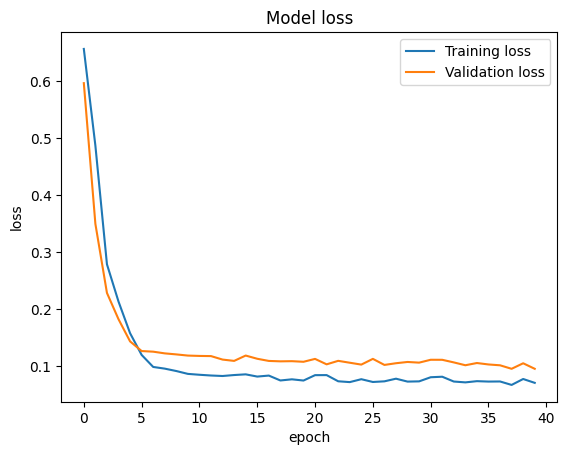

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


<Figure size 640x480 with 0 Axes>

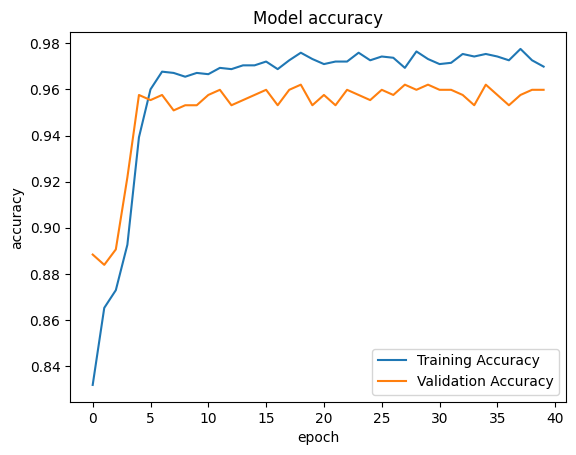

2023-05-31 16:55:06.138516: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-31 16:55:06.139733: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-31 16:55:06.140808: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

7/7 - 2s - 2s/epoch - 336ms/step
[[305  11]
 [  7 125]]


2023-05-31 16:55:08.806309: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-31 16:55:08.807705: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-31 16:55:08.808704: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

29/29 - 2s - 2s/epoch - 78ms/step
[[1253   23]
 [  14  536]]


<Figure size 640x480 with 0 Axes>

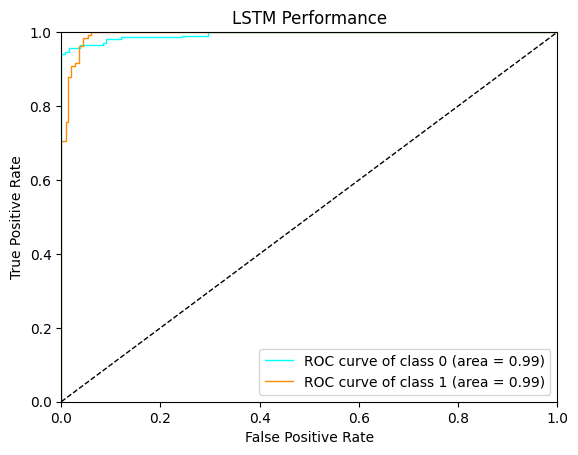

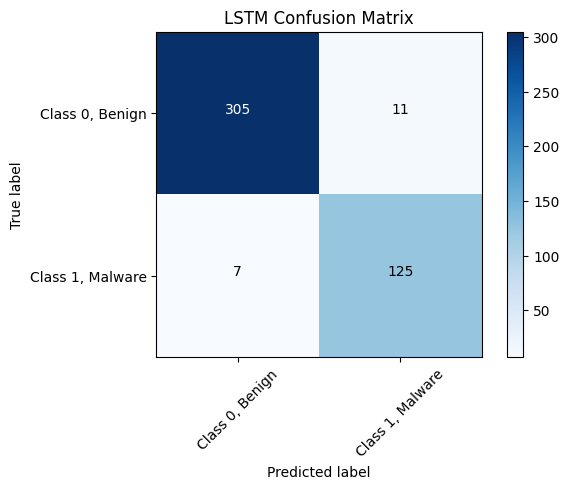

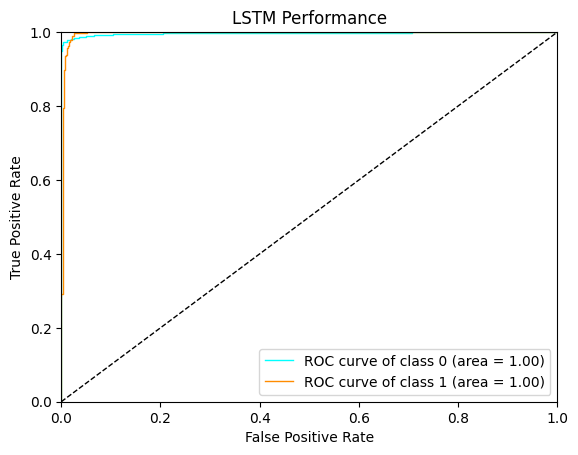

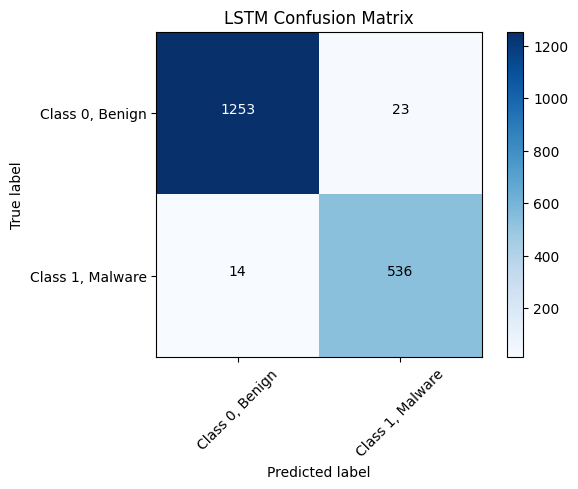

In [8]:
# Plotting loss track 
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()
plt.show()
plt.savefig("model_loss" + ".png")

print(history.history.keys())
# summarize history for accuracy
plt.figure() 
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend()
plt.show()
plt.savefig("model_accuracy" + ".png")


# Predict Test Data and Plot ROC
pred_y = model.predict(test_x, batch_size=64, verbose=2)
plotroc(test_y, pred_y, 2, 'Testing ROC')
class_names = ['Class 0, Benign', 'Class 1, Malware']
plot_confusion_matrix(test_y, pred_y, class_names, 'test_confusion_matrix')
pred_y = model.predict(train_x, batch_size=64, verbose=2)
plotroc(train_y, pred_y, 2, 'Training ROC')
plot_confusion_matrix(train_y, pred_y, class_names, 'train_confusion_matrix')
